In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import tqdm.notebook as tqdm
import time
import datetime

In [3]:
data_path = 'C:/Users/gianl/Desktop/Gi/Supsi/MartaLauraGiada/Laura/Tweets/'

In [4]:
original_tweets = pd.read_parquet(data_path+"original.parquet", engine="fastparquet")
retweets = pd.read_parquet(data_path+"retweets.parquet", engine="fastparquet")
replies = pd.read_parquet(data_path+"replies.parquet", engine="fastparquet")
quotes = pd.read_parquet(data_path+"quotes.parquet", engine="fastparquet")

In [8]:
tweets = pd.read_parquet(destination_path+"tweets.parquet", engine="fastparquet")
# tweets.head()

#### Retweets

In [10]:
retweets = tweets.dropna(subset=['rt_created_at'])

In [11]:
print(f'Percentage of Retweets: {round(len(retweets)/len(tweets)*100,2)} %')

Percentage of Retweets: 59.57 %


In [12]:
retweets.to_parquet(destination_path+"retweets.parquet", index=False)

#### Quotes

In [13]:
quotes = tweets[tweets["quoted_status_id"].notna() & tweets["rt_created_at"].isna()]

In [15]:
print(f'Percentage of Quotes: {round(len(quotes)/len(tweets)*100,2)} %')

Percentage of Quotes: 6.58 %


In [20]:
quotes.to_parquet(destination_path+"quotes.parquet", index=False)

#### Replies

In [16]:
replies = tweets[tweets["in_reply_to_user_id"].notna() & tweets["quoted_status_id"].isna()]

In [19]:
replies.to_parquet(destination_path+"replies.parquet", index=False)

In [17]:
print(f'Percentage of Replies: {round(len(replies)/len(tweets)*100,2)} %')

Percentage of Replies: 15.79 %


#### Original tweets

In [21]:
original_tweets = tweets[tweets["in_reply_to_screen_name"].isna() & tweets["rt_created_at"].isna() & tweets["quoted_status_id"].isna()]

In [22]:
print(f'Percentage of Original tweets: {round(len(original_tweets)/len(tweets)*100,2)} %')

Percentage of Original tweets: 18.06 %


In [23]:
original_tweets.to_parquet(destination_path+"original.parquet", index=False)

#### User Deleted / Supended

In [11]:
def process_datetime(data):
    if ((data == "nan") or (data == "False") or (data == "None")):
        month = "01"
        day = "01"
        year = "2006"
    else:
        x = data.split()
        month = str(time.strptime(x[1], '%b').tm_mon)
        day = str(x[2])
        year = str(x[5])
    formatted_data = day + "-" + month + "-" + year
    data = str(datetime.datetime.strptime(formatted_data, '%d-%m-%Y')).split()[0]
    return data

In [21]:
creation_replies = []
creation_retweets = []
creation_original = []
creation_quotes = []
for i in tqdm.tqdm(replies["created_at"]):
    creation_replies.append(process_datetime(i))
for i in tqdm.tqdm(retweets["created_at"]):
    creation_retweets.append(process_datetime(i))
for i in tqdm.tqdm(original_tweets["created_at"]):
    creation_original.append(process_datetime(i))
for i in tqdm.tqdm(quotes["created_at"]):
    creation_quotes.append(process_datetime(i))   
replies["date"] = creation_replies
retweets["date"] = creation_retweets
quotes["date"] = creation_quotes
original_tweets["date"] = creation_original

In [22]:
replies['date_tweets']= replies.groupby(['date'])['created_at'].transform('size')
original_tweets['date_tweets']= original_tweets.groupby(['date'])['created_at'].transform('size')
retweets['date_tweets']= retweets.groupby(['date'])['created_at'].transform('size')
quotes['date_tweets']= quotes.groupby(['date'])['created_at'].transform('size')

In [23]:
replies = replies.drop_duplicates(subset='date')
original_tweets = original_tweets.drop_duplicates(subset='date')
retweets = retweets.drop_duplicates(subset='date')
quotes = quotes.drop_duplicates(subset='date')

In [28]:
replies["date"]

0         2020-01-27
29        2020-01-28
314       2020-01-03
369       2020-01-30
692       2020-01-31
             ...    
619728    2021-05-13
623755    2021-05-14
627563    2021-05-15
630711    2021-05-16
634915    2021-05-17
Name: date, Length: 366, dtype: object

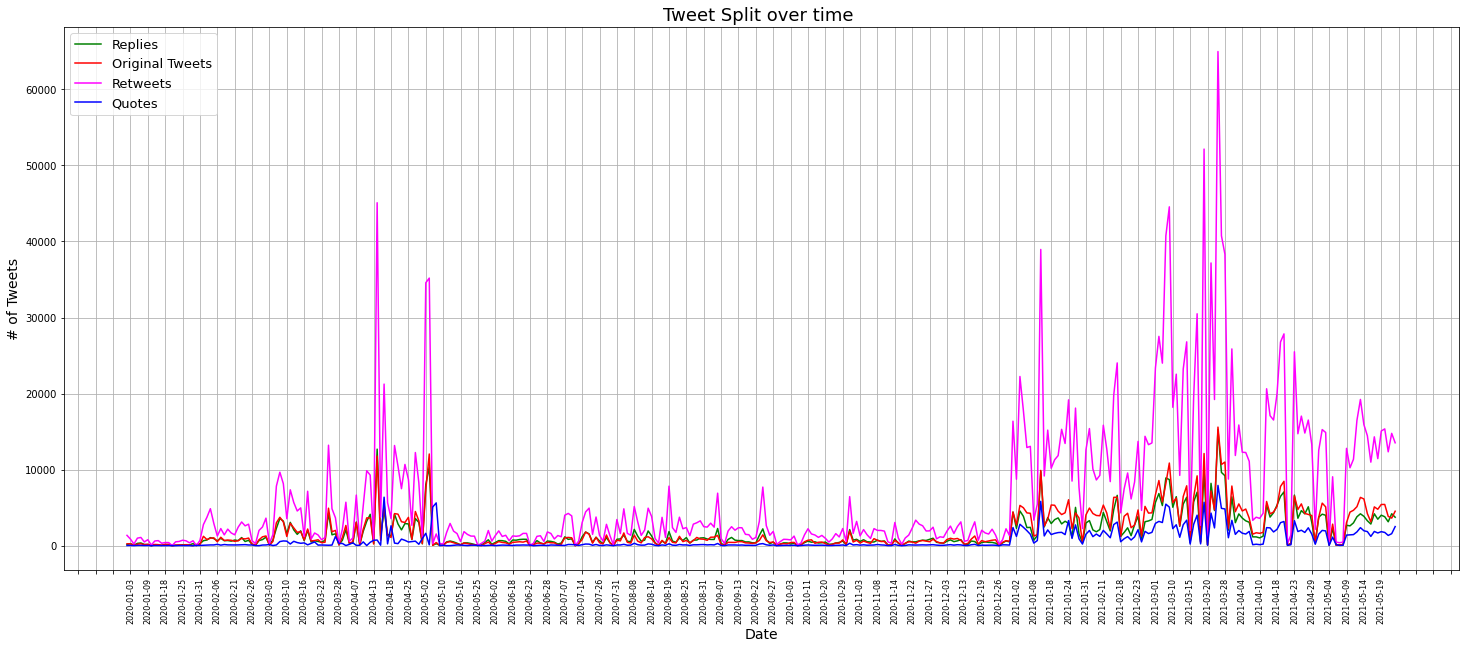

In [29]:
fig, ax = plt.subplots(figsize=(25, 10))
plt.title('Tweet Split over time ', fontsize=18)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('# of Tweets', fontsize=14)

plt.plot(sorted(replies['date']), replies['date_tweets'], c='green', label='Replies')
plt.plot(sorted(original_tweets['date']), original_tweets['date_tweets'], c='r', label='Original Tweets')
plt.plot(sorted(retweets['date']), retweets['date_tweets'], c='magenta', label='Retweets')
plt.plot(sorted(quotes['date']), quotes['date_tweets'], c='b', label='Quotes')
# set monthly locator
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
# set formatter
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# set font and rotation for date tick labels
plt.xticks(rotation='vertical', fontsize = 8) 
plt.legend(loc='upper left', fontsize=13);
plt.grid()
plt.show()

#### Summary

In [24]:
print(f"Checksum: {len(original_tweets) + len(retweets) + len(replies) + len(quotes) == len(tweets)}")

Checksum: True


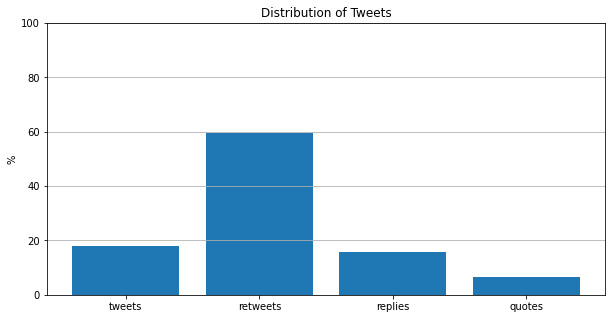

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.bar(np.arange(4), np.asarray([len(original_tweets), len(retweets), len(replies), len(quotes)])*(100/len(tweets)))
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['tweets', 'retweets', 'replies', 'quotes'])
ax.set_ylabel('%')
ax.yaxis.grid(True)
ax.set_ylim([0,100])
ax.set_title('Distribution of Tweets')
plt.show()